In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline
df_text = pd.read_csv ("/home/niddal/Desktop/PhD_projects/Twitter_analysis/Datasets/MHC_Datasets/Final_ones/Full_Dataset_Text.csv")
df_text.head(2)

,tweet,label
0,يارب أفوز 😫😫♥️♥️ #حاشي_باشا_50فرع ع,0
1,#حاشي_باشا_50فرع اللهم اغث البلاد والعباد,0


In [2]:
ham_df= df_text[df_text['label'] == 0]
spam_df= df_text[df_text['label'] == 1]

In [3]:
df_text_New = df_text[pd.notnull(df_text['tweet'])]

In [4]:
df_text_New['tweet'].apply(lambda x: len(x.split(' '))).sum()

34239

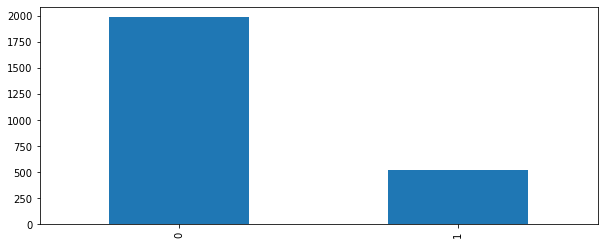

In [5]:
my_tags = ['non_spam','spam']
plt.figure(figsize=(10,4))
df_text_New.label.value_counts().plot(kind='bar');

In [6]:
def print_plot(index):
    example = df_text_New[df_text_New.index == index][['label', 'tweet']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tweet:', example[1])

In [7]:
print_plot(0)

0
Tweet: يارب أفوز 😫😫♥️♥️ #حاشي_باشا_50فرع ع


In [8]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

In [9]:
def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")

    return lst

In [10]:
from stop_words import get_stop_words
stop_words = get_stop_words('arabic')

In [11]:
df_text_New['tweet']= clean_tweets(df_text_New['tweet'])


<ipython-input-11-0c84286979ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text_New['tweet']= clean_tweets(df_text_New['tweet'])


In [12]:
df_text_New['tweet'].apply(lambda x: len(x.split(' '))).sum()

33017

In [13]:
df_text_New.tweet[55]

'#حاشي_باشا_50فرع يأتي بِهاَ الله إن الله لطيفٌ خبير '

# Doc2vec and Logistic Regression

In [11]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

/home/niddal/anaconda3/envs/py2/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [12]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_text_New.tweet, df_text_New.label, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [14]:
all_data[2]

TaggedDocument(words=['RT', '@4YkskI0WIIIWUHX:', '#تركي_ال_شيخ_ادعم_توب_رايد', 'براتب', 'يبدأ', 'من', '١٠٠٠', 'الى٢٠٠٠', 'ريال', 'بدون', 'دوام', 'العدد', 'المطلوب', '20', 'فقط', 'الخاص', 'مفتوح', 'للتسجيل', 'ر…'], tags=['Train_2'])

In [15]:
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 2508/2508 [00:00<00:00, 3022791.50it/s]


In [16]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
    
model_dbow.save('./doc2vec.model')

100%|██████████| 2508/2508 [00:00<00:00, 2156923.20it/s]


In [17]:
model = Doc2Vec.load('./doc2vec.model')

In [18]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [19]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [20]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = RandomForestClassifier()
logreg.fit(train_vectors_dbow, y_train)

RandomForestClassifier()

In [21]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [22]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_pred,y_test, target_names=my_tags))

accuracy 0.9960159362549801
              precision    recall  f1-score   support

    non_spam       1.00      1.00      1.00       602
        spam       0.98      1.00      0.99       151

    accuracy                           1.00       753
   macro avg       0.99      1.00      0.99       753
weighted avg       1.00      1.00      1.00       753



In [53]:
string = 'كيف'
#string = 'حاشي_باشا_50فرع يأتي بِهاَ الله إن الله لطيفٌ خبير'
#string = ' وبقلك كيف تخس في اسرع وقت بدون عمليات أو تعــب..😷💉\nمع اقوى برامج التخسيس الصحية\n#محمد_بن_سلمان_بين_اهل_حايل↗ أرسل وزنك وطولك عبر الخاص.. 📬'

lists= string.split(' ')
inferred_vector=model_dbow.infer_vector(doc_words=lists,alpha=0.025,steps=500)
ddf = pd.DataFrame(columns=['tag', 'd2v_Vec'])
ddf.loc[0,'d2v_Vec']=list(inferred_vector)

In [54]:
predict=logreg.predict(list(ddf['d2v_Vec']))
print("prediction :", predict)

prediction : [0]
